# LDA主题建模可视化与MBTI主题差异分析

本notebook提供了完整的LDA主题建模可视化解决方案，包括：
1. 使用pyLDAvis进行交互式主题可视化
2. 使用seaborn比较不同MBTI人格类型的主题分布
3. 深入分析各MBTI类型的主题偏好差异

In [70]:
# 导入必要的库
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import gensim.corpora as corpora
from gensim.models import LdaModel
from collections import defaultdict
from data_clean import Data_to_Clean,Data_to_Analyze
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'KaiTi', 'FangSong']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

print("库导入完成！")

库导入完成！


In [71]:
# MBTI类型定义
MBTI_types = [
    'istj', 'isfj', 'infj', 'intj', 
    'istp', 'isfp', 'infp', 'intp', 
    'estp', 'esfp', 'enfp', 'entp', 
    'estj', 'esfj', 'enfj', 'entj'
]

# MBTI维度分组
mbti_dimensions = {
    'E': ['estp', 'esfp', 'enfp', 'entp', 'estj', 'esfj', 'enfj', 'entj'],
    'I': ['istj', 'isfj', 'infj', 'intj', 'istp', 'isfp', 'infp', 'intp'],
    'S': ['istj', 'isfj', 'istp', 'isfp', 'estp', 'esfp', 'estj', 'esfj'],
    'N': ['infj', 'intj', 'infp', 'intp', 'enfp', 'entp', 'enfj', 'entj'],
    'T': ['intj', 'intp', 'entj', 'entp', 'istj', 'istp', 'estj', 'estp'],
    'F': ['isfj', 'infj', 'isfp', 'infp', 'esfj', 'enfj', 'esfp', 'enfp'],
    'J': ['istj', 'isfj', 'infj', 'intj', 'estj', 'esfj', 'enfj', 'entj'],
    'P': ['istp', 'isfp', 'infp', 'intp', 'estp', 'esfp', 'enfp', 'entp']
}

print("MBTI类型定义完成！")

MBTI类型定义完成！


In [72]:
# 加载LDA模型和数据
def load_lda_data():
    """加载LDA模型和相关数据"""
    try:
        # 加载LDA模型
        lda_model = pickle.load(open("output/lda_model/lda_18_5051.pkl", "rb"))
        print(f"LDA模型加载成功，主题数量: {lda_model.num_topics}")
        
        # 加载原始文本数据
        all_original_text = pickle.load(open("Data/all_original_text.pkl", "rb"))
        print(f"原始文本数据加载成功，文档数量: {len(all_original_text)}")
        
        return lda_model, all_original_text
    except FileNotFoundError as e:
        print(f"文件未找到: {e}")
        return None, None
    except Exception as e:
        print(f"加载数据时出错: {e}")
        return None, None

# 加载按MBTI类型分类的清洗数据
def load_mbti_data():
    """加载按MBTI类型分类的清洗数据"""
    cleaned_data = {}
    
    for mbti_type in MBTI_types:
        file_path = f"Data/cleaned_data/{mbti_type}_cleaned.pkl"
        try:
            with open(file_path, 'rb') as f:
                cleaned_data[mbti_type] = pickle.load(f)
            print(f"{mbti_type.upper()} 数据加载成功")
        except FileNotFoundError:
            print(f"警告: 未找到 {mbti_type.upper()} 的数据文件")
            cleaned_data[mbti_type] = []
        except Exception as e:
            print(f"加载 {mbti_type.upper()} 数据时出错: {e}")
            cleaned_data[mbti_type] = []
    
    return cleaned_data

# 执行数据加载
lda_model, all_original_text = load_lda_data()
mbti_cleaned_data = load_mbti_data()

LDA模型加载成功，主题数量: 18
原始文本数据加载成功，文档数量: 7811
ISTJ 数据加载成功
ISFJ 数据加载成功
INFJ 数据加载成功
INTJ 数据加载成功
ISTP 数据加载成功
ISFP 数据加载成功
INFP 数据加载成功
INTP 数据加载成功
ESTP 数据加载成功
ESFP 数据加载成功
ENFP 数据加载成功
ENTP 数据加载成功
ESTJ 数据加载成功
ESFJ 数据加载成功
ENFJ 数据加载成功
ENTJ 数据加载成功


In [73]:
# 创建LDA可视化类
class LDATopicAnalyzer:
    def __init__(self, lda_model, texts, mbti_data):
        self.model = lda_model
        self.texts = texts
        self.mbti_data = mbti_data
        self.dictionary = lda_model.id2word
        self.corpus = [self.dictionary.doc2bow(text) for text in texts]
        self.topic_distributions = None
        self.mbti_topic_distributions = None
        
    def create_pyldavis_visualization(self, save_path="output/lda_visualization.html"):
        """创建pyLDAvis交互式可视化"""
        print("正在创建pyLDAvis可视化...")
        
        # 准备pyLDAvis可视化
        vis_data = gensimvis.prepare(
            self.model, 
            self.corpus, 
            self.dictionary,
            sort_topics=False
        )
        
        # 保存为HTML文件
        pyLDAvis.save_html(vis_data, save_path)
        print(f"pyLDAvis可视化已保存到: {save_path}")
        
        # 在notebook中显示
        pyLDAvis.enable_notebook()
        return pyLDAvis.display(vis_data)
    
    def get_topic_distributions(self):
        """获取文档的主题分布"""
        print("正在计算主题分布...")
        
        topic_distributions = []
        for doc_bow in tqdm(self.corpus, desc="计算主题分布"):
            doc_topics = self.model.get_document_topics(doc_bow, minimum_probability=0)
            topic_probs = [prob for _, prob in doc_topics]
            topic_distributions.append(topic_probs)
        
        self.topic_distributions = np.array(topic_distributions)
        return self.topic_distributions
    
    def calculate_mbti_topic_distributions(self):
        """计算每个MBTI类型的主题分布"""
        print("正在计算MBTI类型的主题分布...")
        
        mbti_topic_dist = {}
        
        for mbti_type in MBTI_types:
            if mbti_type in self.mbti_data and len(self.mbti_data[mbti_type].data) > 0:
                # 为该MBTI类型的文档创建语料库
                mbti_corpus = [self.dictionary.doc2bow(doc) for doc in self.mbti_data[mbti_type].data["posts"]]
                
                # 计算主题分布
                topic_sums = np.zeros(self.model.num_topics)
                doc_count = 0
                
                for doc_bow in mbti_corpus:
                    doc_topics = self.model.get_document_topics(doc_bow, minimum_probability=0)
                    for topic_id, prob in doc_topics:
                        topic_sums[topic_id] += prob
                    doc_count += 1
                
                # 计算平均主题分布
                if doc_count > 0:
                    mbti_topic_dist[mbti_type] = topic_sums / doc_count
                else:
                    mbti_topic_dist[mbti_type] = np.zeros(self.model.num_topics)
            else:
                mbti_topic_dist[mbti_type] = np.zeros(self.model.num_topics)
        
        self.mbti_topic_distributions = mbti_topic_dist
        return mbti_topic_dist
    
    def get_topic_words(self, num_words=10):
        """获取每个主题的关键词"""
        topic_words = {}
        for topic_id in range(self.model.num_topics):
            words = self.model.show_topic(topic_id, topn=num_words)
            topic_words[topic_id] = [word for word, _ in words]
        return topic_words

# 创建分析器实例
if lda_model and all_original_text:
    analyzer = LDATopicAnalyzer(lda_model, all_original_text, mbti_cleaned_data)
    print("LDA主题分析器创建成功！")
else:
    print("无法创建分析器，请检查数据加载是否成功")

LDA主题分析器创建成功！


In [74]:
# 创建pyLDAvis交互式可视化
if 'analyzer' in locals():
    print("正在生成pyLDAvis交互式可视化...")
    vis = analyzer.create_pyldavis_visualization()
    print("\n可视化说明:")
    print("- 左侧圆圈代表不同主题，圆圈大小表示主题的流行度")
    print("- 圆圈之间的距离表示主题间的相似性")
    print("- 右侧显示选中主题的关键词")
    print("- 可以调整λ参数来平衡词频和主题特异性")
else:
    print("分析器未创建，跳过可视化")

正在生成pyLDAvis交互式可视化...
正在创建pyLDAvis可视化...
pyLDAvis可视化已保存到: output/lda_visualization.html

可视化说明:
- 左侧圆圈代表不同主题，圆圈大小表示主题的流行度
- 圆圈之间的距离表示主题间的相似性
- 右侧显示选中主题的关键词
- 可以调整λ参数来平衡词频和主题特异性


In [84]:
# 计算MBTI类型的主题分布
if 'analyzer' in locals():
    mbti_topic_dist = analyzer.calculate_mbti_topic_distributions()
    topic_words = analyzer.get_topic_words()
    
    # 创建主题分布DataFrame
    topic_dist_df = pd.DataFrame(mbti_topic_dist).T
    topic_dist_df.columns = [f"Topic {i}" for i in range(len(topic_dist_df.columns))]
    
    print("MBTI类型主题分布计算完成！")
    print(f"主题分布矩阵形状: {topic_dist_df.shape}")
    
    # 显示前几行
    print("\n各MBTI类型的主题分布预览:")
    display(topic_dist_df.head())
else:
    print("分析器未创建，跳过主题分布计算")

正在计算MBTI类型的主题分布...
MBTI类型主题分布计算完成！
主题分布矩阵形状: (16, 18)

各MBTI类型的主题分布预览:


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17
istj,0.075139,0.068750,0.018840,0.049728,0.063777,0.032526,0.059728,0.005203,0.067484,0.012194,0.033650,0.010437,0.015941,0.053615,0.371063,0.027390,0.012364,0.022171
isfj,0.091213,0.111711,0.029549,0.066805,0.057385,0.103086,0.131451,0.012728,0.102595,0.011244,0.037366,0.012818,0.042342,0.081706,0.000279,0.037083,0.019433,0.051205
infj,0.128311,0.095186,0.034639,0.071558,0.125137,0.066144,0.090431,0.010049,0.119096,0.009092,0.069207,0.017510,0.034360,0.040710,0.000299,0.023348,0.011140,0.053784
intj,0.137048,0.109328,0.025407,0.078787,0.169933,0.041899,0.079563,0.012442,0.110189,0.010413,0.081970,0.016679,0.028250,0.025716,0.001494,0.026246,0.011480,0.033156
istp,0.092079,0.198236,0.042499,0.100048,0.041499,0.072609,0.125210,0.011356,0.075895,0.010357,0.039836,0.023498,0.030415,0.036963,0.000271,0.061442,0.014427,0.023358


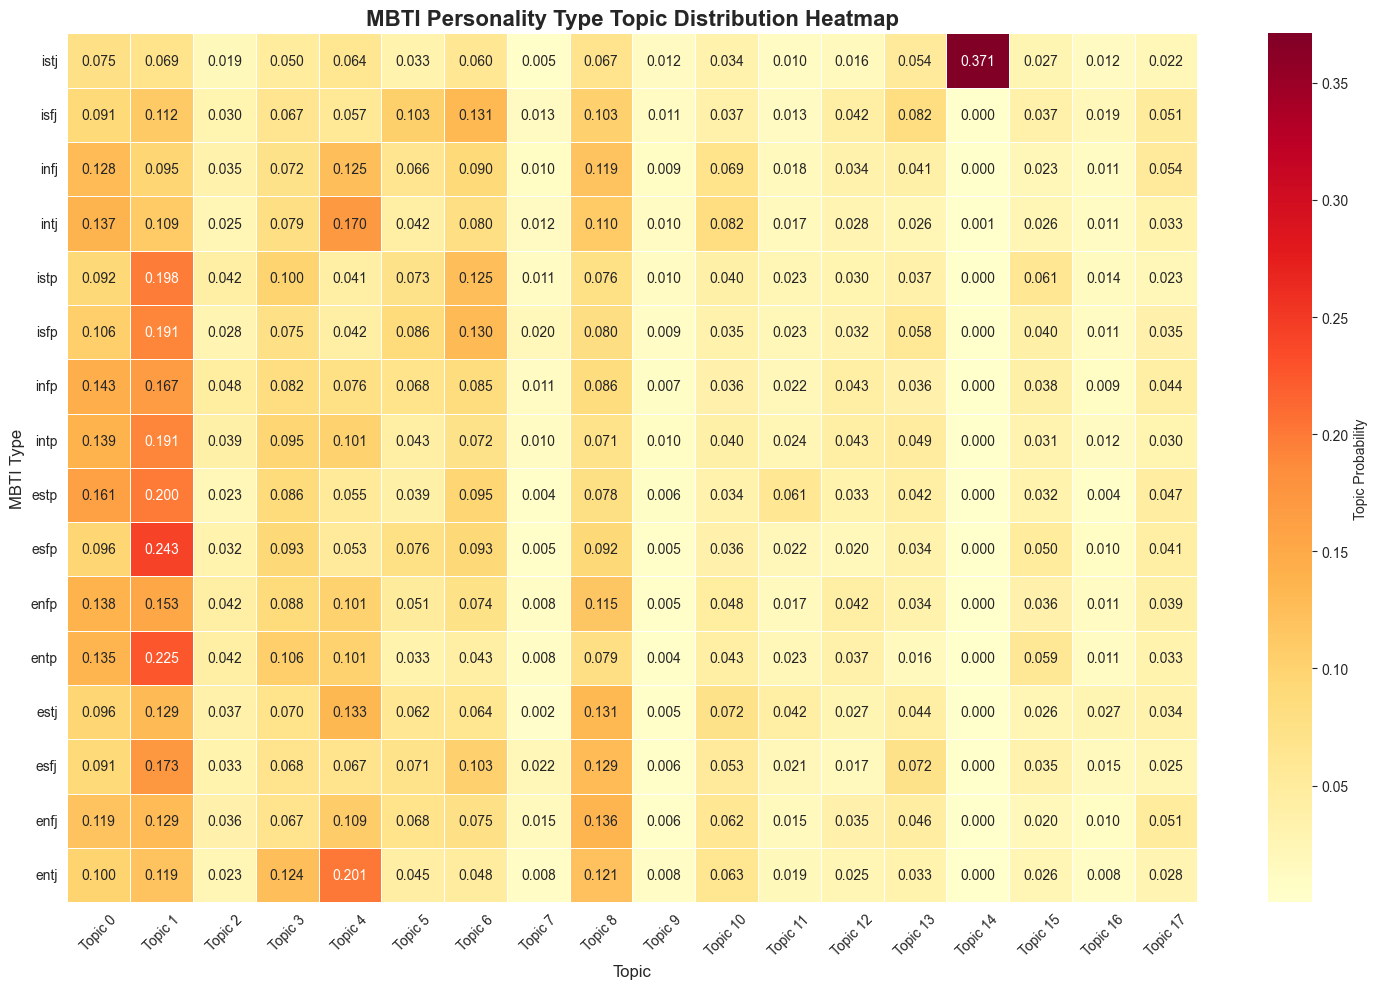

In [85]:
# 使用seaborn创建主题分布热力图
def create_topic_heatmap(topic_dist_df, figsize=(15, 10)):
    """创建MBTI类型主题分布热力图"""
    plt.figure(figsize=figsize)
    
    # 创建热力图
    sns.heatmap(
        topic_dist_df, 
        annot=True, 
        fmt='.3f', 
        cmap='YlOrRd',
        cbar_kws={'label': 'Topic Probability'},
        linewidths=0.5
    )
    
    plt.title('MBTI Personality Type Topic Distribution Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Topic', fontsize=12)
    plt.ylabel('MBTI Type', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # 保存图片
    plt.savefig('output/mbti_topic_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'topic_dist_df' in locals():
    create_topic_heatmap(topic_dist_df)
else:
    print("主题分布数据未准备好，跳过热力图创建")

MBTI维度主题偏好分析:


,E,I,S,N,T,F,J,P
Topic 0,0.116909,0.113835,0.100848,0.129896,0.116747,0.113997,0.104629,0.126115
Topic 1,0.171472,0.141560,0.164273,0.148759,0.155246,0.157786,0.116912,0.196121
Topic 2,0.033515,0.033226,0.030438,0.036303,0.031368,0.035372,0.029699,0.037042
Topic 3,0.087614,0.077351,0.075949,0.089015,0.088686,0.076278,0.074414,0.090551
Topic 4,0.102545,0.084462,0.064165,0.122842,0.108295,0.078712,0.115815,0.071192


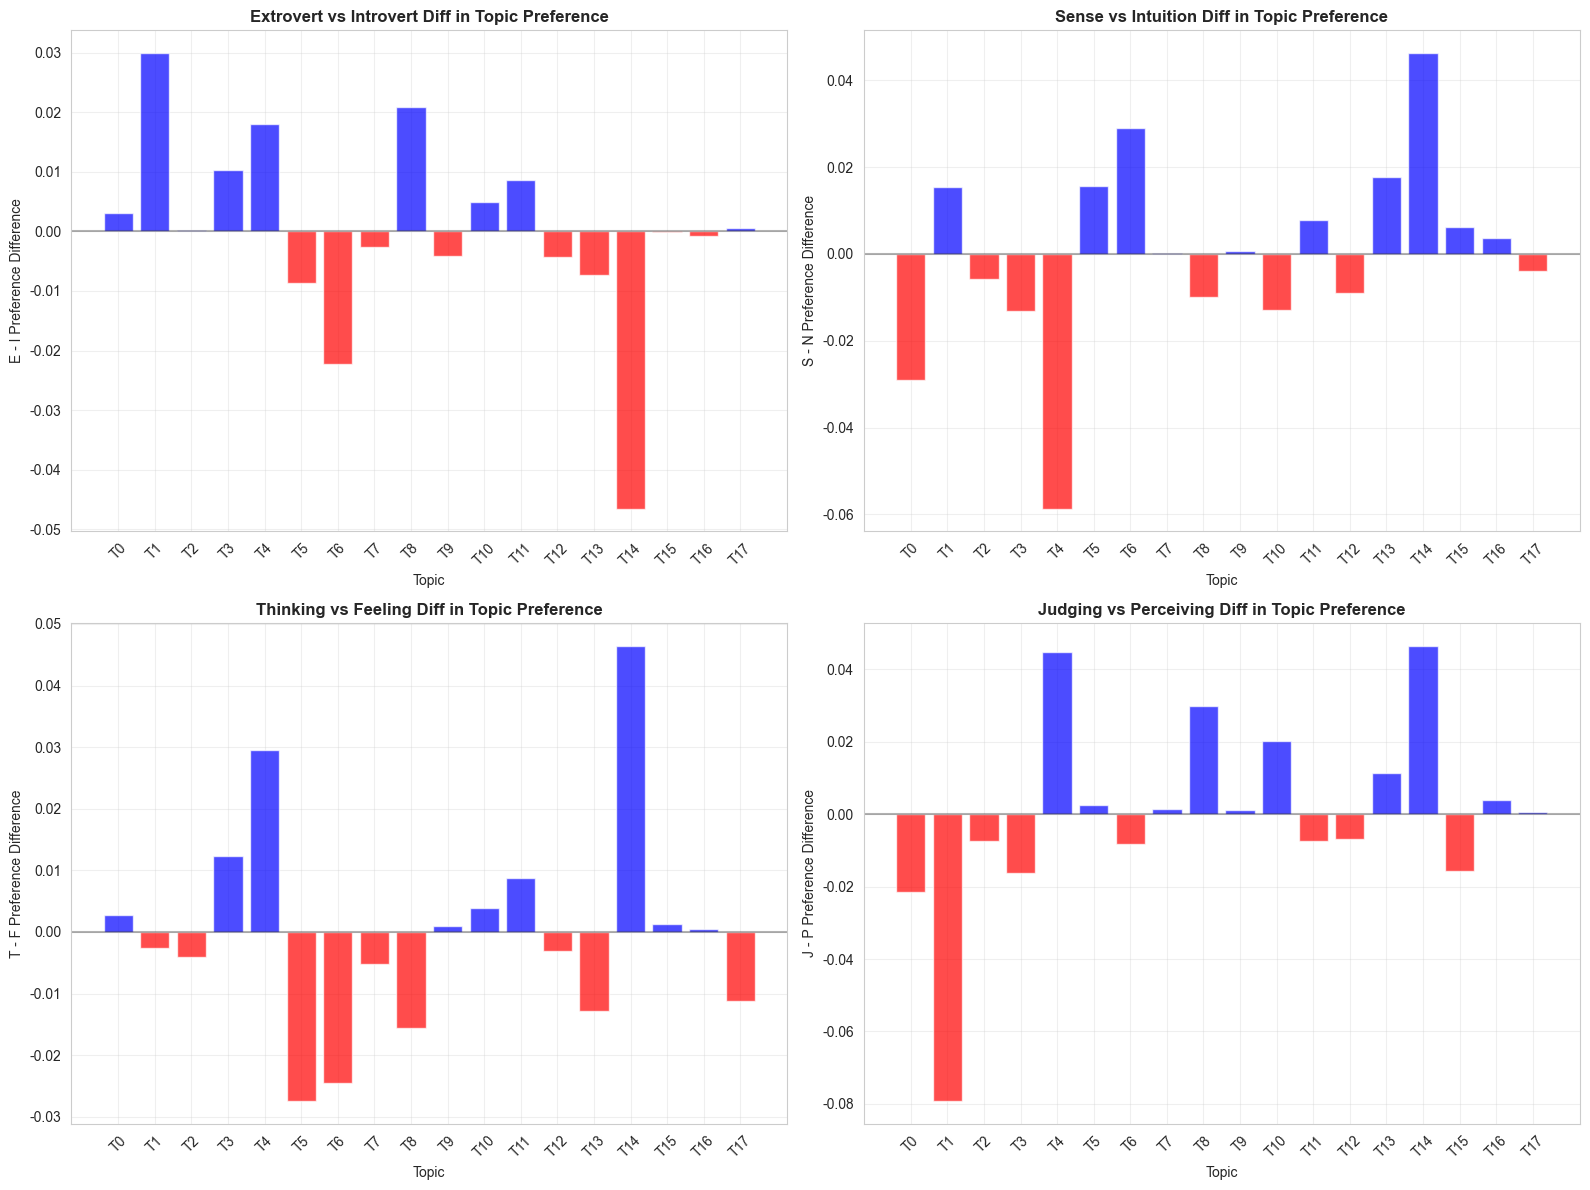

In [86]:
# 创建MBTI维度的主题偏好分析
def analyze_mbti_dimensions(topic_dist_df):
    """分析MBTI四个维度的主题偏好"""
    dimension_analysis = {}
    
    for dim, types in mbti_dimensions.items():
        # 计算该维度类型的平均主题分布
        dim_types_in_data = [t for t in types if t in topic_dist_df.index]
        if dim_types_in_data:
            dimension_analysis[dim] = topic_dist_df.loc[dim_types_in_data].mean()
    
    return pd.DataFrame(dimension_analysis)

def create_dimension_comparison(dimension_df):
    """创建MBTI维度主题偏好比较图"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    dimension_pairs = [('E', 'I'), ('S', 'N'), ('T', 'F'), ('J', 'P')]
    pair_names = ['Extrovert vs Introvert', 'Sense vs Intuition', 'Thinking vs Feeling', 'Judging vs Perceiving']
    
    for i, ((dim1, dim2), pair_name) in enumerate(zip(dimension_pairs, pair_names)):
        if dim1 in dimension_df.columns and dim2 in dimension_df.columns:
            # 计算差异
            diff = dimension_df[dim1] - dimension_df[dim2]
            
            # 创建条形图
            x_pos = range(len(diff))
            colors = ['red' if x < 0 else 'blue' for x in diff]
            
            axes[i].bar(x_pos, diff, color=colors, alpha=0.7)
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            axes[i].set_title(f'{pair_name} Diff in Topic Preference', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Topic')
            axes[i].set_ylabel(f'{dim1} - {dim2} Preference Difference')
            axes[i].set_xticks(x_pos)
            axes[i].set_xticklabels([f'T{j}' for j in range(len(diff))], rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/mbti_dimension_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'topic_dist_df' in locals():
    dimension_df = analyze_mbti_dimensions(topic_dist_df)
    print("MBTI维度主题偏好分析:")
    display(dimension_df.head())
    
    create_dimension_comparison(dimension_df)
else:
    print("主题分布数据未准备好，跳过维度分析")

In [78]:
# 创建主题关键词云图
def create_topic_wordcloud_summary(topic_words, topic_dist_df):
    """创建主题关键词摘要"""
    print("=" * 60)
    print("主题关键词摘要")
    print("=" * 60)
    
    # 计算每个主题的总体流行度
    topic_popularity = topic_dist_df.mean().sort_values(ascending=False)
    
    for i, (topic_idx, popularity) in enumerate(topic_popularity.items()):
        topic_num = int(topic_idx.replace('主题', ''))
        print(f"\n主题 {topic_num} (流行度: {popularity:.3f}):")
        print(f"关键词: {', '.join(topic_words[topic_num][:8])}")
        
        # 找出最偏好这个主题的MBTI类型
        topic_col = f"主题{topic_num}"
        if topic_col in topic_dist_df.columns:
            top_mbti = topic_dist_df[topic_col].nlargest(3)
            print(f"最偏好的MBTI类型: {', '.join([f'{mbti}({score:.3f})' for mbti, score in top_mbti.items()])}")
        
        if i >= 9:  # 只显示前10个最流行的主题
            break

if 'topic_words' in locals() and 'topic_dist_df' in locals():
    create_topic_wordcloud_summary(topic_words, topic_dist_df)
else:
    print("数据未准备好，跳过主题摘要")

主题关键词摘要

主题 1 (流行度: 0.157):
关键词: yall, shut, bitch, j, reply, pride, goodnight, block
最偏好的MBTI类型: esfp(0.243), entp(0.226), estp(0.200)

主题 0 (流行度: 0.115):
关键词: draw, chapter, anime, series, piece, fic, scene, especially
最偏好的MBTI类型: estp(0.161), infp(0.143), intp(0.138)

主题 8 (流行度: 0.100):
关键词: car, summer, dog, drive, photo, coffee, season, ticket
最偏好的MBTI类型: enfj(0.136), estj(0.131), esfj(0.129)

主题 4 (流行度: 0.093):
关键词: state, child, country, american, law, trump, human, gun
最偏好的MBTI类型: entj(0.201), intj(0.170), estj(0.133)

主题 6 (流行度: 0.085):
关键词: txt, group, concert, comeback, member, kpop, debut, beomgyu
最偏好的MBTI类型: isfj(0.131), isfp(0.130), istp(0.125)

主题 3 (流行度: 0.083):
关键词: food, drink, water, bitch, fast, weight, sick, fat
最偏好的MBTI类型: entj(0.124), entp(0.106), istp(0.100)

主题 5 (流行度: 0.060):
关键词: skz, chan, lee, hyunjin, concert, felix, aye, mark
最偏好的MBTI类型: isfj(0.103), isfp(0.086), esfp(0.075)

主题 10 (流行度: 0.049):
关键词: automatically, unfollowed, experience, create, self, st

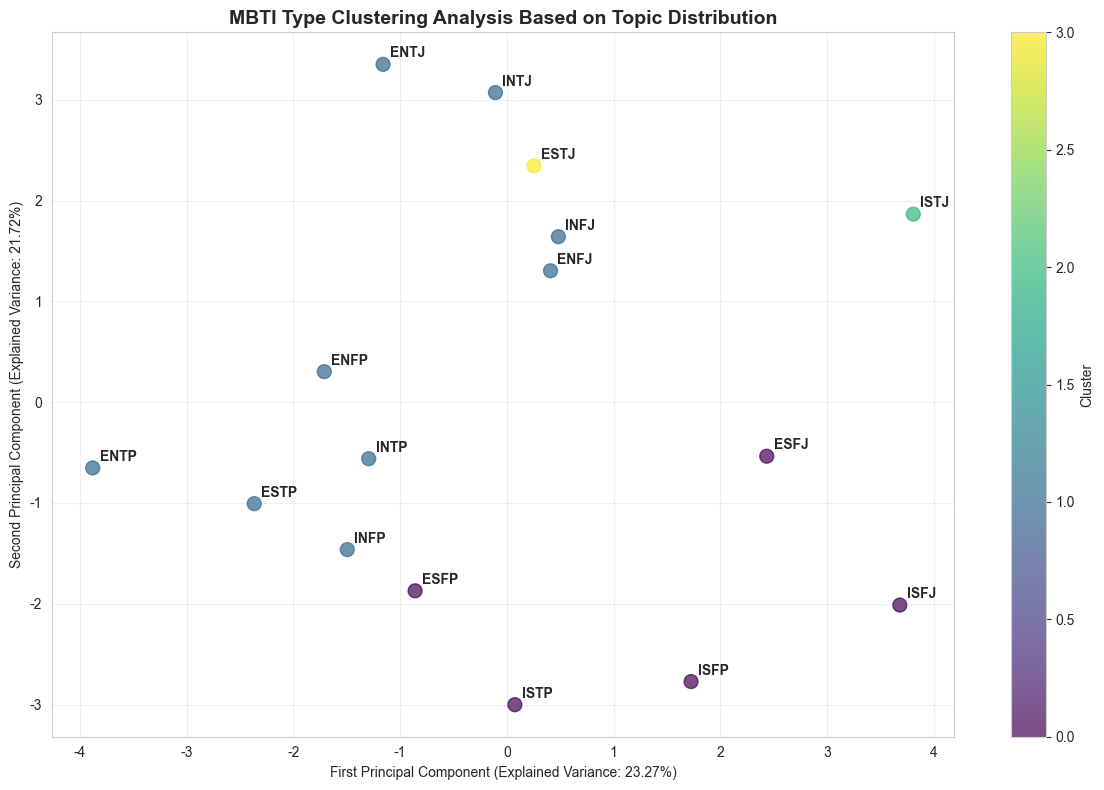


MBTI类型聚类结果:
聚类 0: ISFJ, ISTP, ISFP, ESFP, ESFJ
聚类 1: INFJ, INTJ, INFP, INTP, ESTP, ENFP, ENTP, ENFJ, ENTJ
聚类 2: ISTJ
聚类 3: ESTJ


In [87]:
# 创建MBTI类型聚类分析
def create_mbti_clustering_analysis(topic_dist_df):
    """基于主题分布对MBTI类型进行聚类分析"""
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # 标准化数据
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(topic_dist_df)
    
    # PCA降维
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    # K-means聚类
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    # 创建可视化
    plt.figure(figsize=(12, 8))
    
    # 绘制散点图
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.7)
    
    # 添加MBTI类型标签
    for i, mbti_type in enumerate(topic_dist_df.index):
        plt.annotate(mbti_type.upper(), (pca_data[i, 0], pca_data[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    plt.title('MBTI Type Clustering Analysis Based on Topic Distribution', fontsize=14, fontweight='bold')
    plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/mbti_clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印聚类结果
    print("\nMBTI类型聚类结果:")
    for cluster_id in range(4):
        cluster_types = [topic_dist_df.index[i] for i, c in enumerate(clusters) if c == cluster_id]
        print(f"聚类 {cluster_id}: {', '.join([t.upper() for t in cluster_types])}")

if 'topic_dist_df' in locals():
    try:
        create_mbti_clustering_analysis(topic_dist_df)
    except ImportError:
        print("需要安装scikit-learn库来进行聚类分析")
        print("请运行: pip install scikit-learn")
else:
    print("主题分布数据未准备好，跳过聚类分析")

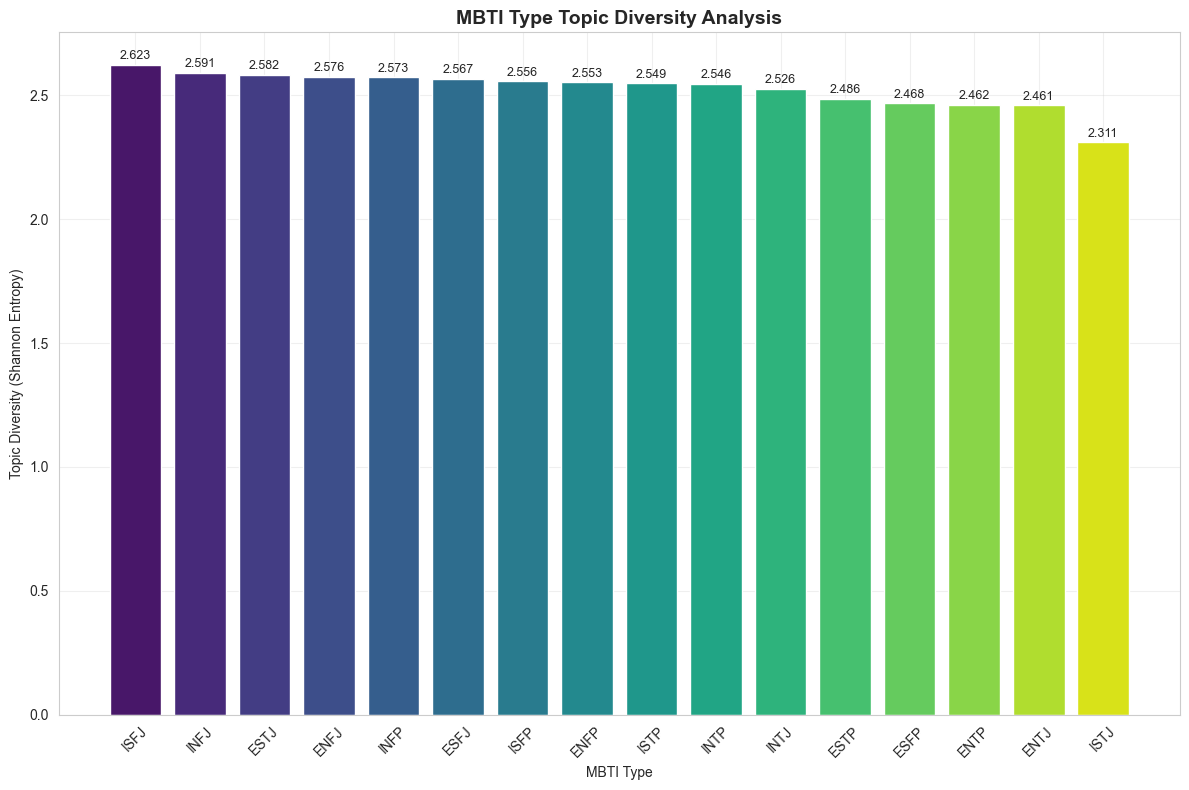


MBTI类型主题多样性排名:


,MBTI Type,Topic Diversity
1,isfj,2.623096
2,infj,2.591198
12,estj,2.582109
14,enfj,2.575945
6,infp,2.572521
13,esfj,2.567423
5,isfp,2.555940
10,enfp,2.553137
4,istp,2.548678
7,intp,2.546451



分析说明:
- 主题多样性越高，表示该MBTI类型讨论的主题越广泛
- 主题多样性越低，表示该MBTI类型更专注于特定主题


In [89]:
# 创建主题多样性分析
def analyze_topic_diversity(topic_dist_df):
    """分析每个MBTI类型的主题多样性"""
    from scipy.stats import entropy
    
    diversity_scores = {}
    
    for mbti_type in topic_dist_df.index:
        # 计算香农熵作为多样性指标
        probs = topic_dist_df.loc[mbti_type].values
        # 避免log(0)
        probs = probs + 1e-10
        diversity_scores[mbti_type] = entropy(probs)
    
    # 创建多样性排序
    diversity_df = pd.DataFrame(list(diversity_scores.items()), 
                               columns=['MBTI Type', 'Topic Diversity'])
    diversity_df = diversity_df.sort_values('Topic Diversity', ascending=False)
    
    # 可视化
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(diversity_df)), diversity_df['Topic Diversity'], 
                   color=sns.color_palette("viridis", len(diversity_df)))
    
    plt.title('MBTI Type Topic Diversity Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('MBTI Type')
    plt.ylabel('Topic Diversity (Shannon Entropy)')
    plt.xticks(range(len(diversity_df)), 
               [t.upper() for t in diversity_df['MBTI Type']], rotation=45)
    
    # 添加数值标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/mbti_topic_diversity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return diversity_df

if 'topic_dist_df' in locals():
    try:
        diversity_results = analyze_topic_diversity(topic_dist_df)
        print("\nMBTI类型主题多样性排名:")
        display(diversity_results)
        
        print("\n分析说明:")
        print("- 主题多样性越高，表示该MBTI类型讨论的主题越广泛")
        print("- 主题多样性越低，表示该MBTI类型更专注于特定主题")
    except ImportError:
        print("需要scipy库来计算熵")
        print("请运行: pip install scipy")
else:
    print("主题分布数据未准备好，跳过多样性分析")

In [81]:
# 生成综合分析报告
def generate_analysis_report(topic_dist_df, topic_words):
    """生成综合分析报告"""
    print("=" * 80)
    print("MBTI人格类型主题建模分析报告")
    print("=" * 80)
    
    # 1. 总体统计
    print(f"\n1. 总体统计")
    print(f"   - 分析的MBTI类型数量: {len(topic_dist_df)}")
    print(f"   - 主题总数: {len(topic_dist_df.columns)}")
    print(f"   - 平均主题分布标准差: {topic_dist_df.std(axis=1).mean():.4f}")
    
    # 2. 最具特色的主题偏好
    print(f"\n2. 各MBTI类型最偏好的主题")
    for mbti_type in topic_dist_df.index:
        top_topic_idx = topic_dist_df.loc[mbti_type].idxmax()
        top_topic_score = topic_dist_df.loc[mbti_type].max()
        topic_num = int(top_topic_idx.replace('主题', ''))
        top_words = ', '.join(topic_words[topic_num][:5])
        print(f"   {mbti_type.upper()}: {top_topic_idx} ({top_topic_score:.3f}) - {top_words}")
    
    # 3. 主题流行度排名
    print(f"\n3. 主题流行度排名 (前5名)")
    topic_popularity = topic_dist_df.mean().sort_values(ascending=False)
    for i, (topic_idx, popularity) in enumerate(topic_popularity.head().items()):
        topic_num = int(topic_idx.replace('主题', ''))
        top_words = ', '.join(topic_words[topic_num][:5])
        print(f"   {i+1}. {topic_idx} ({popularity:.3f}) - {top_words}")
    
    # 4. MBTI维度差异总结
    print(f"\n4. MBTI维度主要差异")
    dimension_df = analyze_mbti_dimensions(topic_dist_df)
    
    dimension_pairs = [('E', 'I'), ('S', 'N'), ('T', 'F'), ('J', 'P')]
    pair_names = ['外向 vs 内向', '感觉 vs 直觉', '思考 vs 情感', '判断 vs 知觉']
    
    for (dim1, dim2), pair_name in zip(dimension_pairs, pair_names):
        if dim1 in dimension_df.columns and dim2 in dimension_df.columns:
            diff = dimension_df[dim1] - dimension_df[dim2]
            max_diff_topic = diff.abs().idxmax()
            max_diff_value = diff[max_diff_topic]
            topic_num = int(max_diff_topic.replace('主题', ''))
            
            if max_diff_value > 0:
                preferred_dim = dim1
            else:
                preferred_dim = dim2
                max_diff_value = abs(max_diff_value)
            
            top_words = ', '.join(topic_words[topic_num][:3])
            print(f"   {pair_name}: {preferred_dim}更偏好{max_diff_topic} ({max_diff_value:.3f}) - {top_words}")
    
    print(f"\n" + "=" * 80)
    print("分析完成！所有可视化图表已保存到output目录")
    print("=" * 80)

if 'topic_dist_df' in locals() and 'topic_words' in locals():
    generate_analysis_report(topic_dist_df, topic_words)
else:
    print("数据未准备好，跳过报告生成")

MBTI人格类型主题建模分析报告

1. 总体统计
   - 分析的MBTI类型数量: 16
   - 主题总数: 18
   - 平均主题分布标准差: 0.0505

2. 各MBTI类型最偏好的主题
   ISTJ: 主题14 (0.371) - like, know, oh, good, think
   ISFJ: 主题6 (0.131) - txt, group, concert, comeback, member
   INFJ: 主题0 (0.128) - draw, chapter, anime, series, piece
   INTJ: 主题4 (0.170) - state, child, country, american, law
   ISTP: 主题1 (0.198) - yall, shut, bitch, j, reply
   ISFP: 主题1 (0.190) - yall, shut, bitch, j, reply
   INFP: 主题1 (0.167) - yall, shut, bitch, j, reply
   INTP: 主题1 (0.191) - yall, shut, bitch, j, reply
   ESTP: 主题1 (0.200) - yall, shut, bitch, j, reply
   ESFP: 主题1 (0.243) - yall, shut, bitch, j, reply
   ENFP: 主题1 (0.153) - yall, shut, bitch, j, reply
   ENTP: 主题1 (0.226) - yall, shut, bitch, j, reply
   ESTJ: 主题4 (0.133) - state, child, country, american, law
   ESFJ: 主题1 (0.173) - yall, shut, bitch, j, reply
   ENFJ: 主题8 (0.136) - car, summer, dog, drive, photo
   ENTJ: 主题4 (0.201) - state, child, country, american, law

3. 主题流行度排名 (前5名)
   1. 主题1 (0.15

In [82]:
# 保存分析结果
def save_analysis_results(topic_dist_df, dimension_df=None, diversity_results=None):
    """保存分析结果到文件"""
    import os
    
    # 确保输出目录存在
    os.makedirs('output', exist_ok=True)
    
    # 保存主题分布矩阵
    topic_dist_df.to_csv('output/mbti_topic_distributions.csv', encoding='utf-8')
    print("主题分布矩阵已保存到: output/mbti_topic_distributions.csv")
    
    # 保存维度分析结果
    if dimension_df is not None:
        dimension_df.to_csv('output/mbti_dimension_analysis.csv', encoding='utf-8')
        print("维度分析结果已保存到: output/mbti_dimension_analysis.csv")
    
    # 保存多样性分析结果
    if diversity_results is not None:
        diversity_results.to_csv('output/mbti_topic_diversity.csv', encoding='utf-8', index=False)
        print("多样性分析结果已保存到: output/mbti_topic_diversity.csv")
    
    print("\n所有分析结果已保存完成！")

# 执行保存
if 'topic_dist_df' in locals():
    dimension_df_to_save = dimension_df if 'dimension_df' in locals() else None
    diversity_to_save = diversity_results if 'diversity_results' in locals() else None
    save_analysis_results(topic_dist_df, dimension_df_to_save, diversity_to_save)
else:
    print("没有可保存的分析结果")

主题分布矩阵已保存到: output/mbti_topic_distributions.csv
维度分析结果已保存到: output/mbti_dimension_analysis.csv
多样性分析结果已保存到: output/mbti_topic_diversity.csv

所有分析结果已保存完成！
